In [ ]:
##adpated from https://keras.io/examples/generative/vae/

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Week 4.2 Autoencoders

For our generative models, we want something that will

1. Compress our original **high dimensional data** into a lower dimensional ``representation`` or ``latent`` vector


2. Use this ``latent vector`` to generate **new images** that are plausibly from the original set, but also intersting in their variety. 


To do this, we will build **two neural networks** to do each task, and then train them both **at the same time**!.

These neural networks will use very similar structures to those we've seen before (``Dense`` layers and ``Convolution`` operations)


![fishy](../images/vae1.png)

### The Encoder 

Using convolution laters, this first model will take input image (first we'll be working with some ``28x28`` grayscale pictures), and output a ``2 dimensional vector``. 

This will place the image somewhere in latent space!


In [5]:
image_dims = (28, 28, 1)

In [6]:
latent_dim = 2
encoder = Sequential([
    layers.Input(shape = image_dims),
    layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
    ##Output is two numbers
    layers.Dense(latent_dim)
])

In [7]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                50192     
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 69,042
Trainable params: 69,042
Non-trainable params: 0
_________________________________________________________________


### The Decoder 

The second model will take a ``2 dimensional vector`` and convert this back into a ``28x28`` black and white image!

The structure of the ``Encoder`` and ``Decoder`` don't have to match, however....


* The input of the ``Encoder`` and the output of the ``Decoder`` **must have the same shape**


* The input of the ``Decoder`` and the output of the ``Encoder`` **must have the same shape**

In [8]:
image_dims = (128, 128, 1)

In [9]:
quarter = int(image_dims[0]/4)

In [10]:
decoder = Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(quarter * quarter * 64, activation="relu"),
    layers.Reshape((quarter, quarter, 64)),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")
])

In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 65536)             196608    
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 3)      867       
 ranspose)                                                       
                                                      

### Putting it together 

We combine these two models into a final ``Sequential``.

In [12]:
auto_encoder = Sequential([encoder, decoder])

### MNIST

We're first going to try and learn from a dataset consisting of **hand written digits**. This is called [MNIST](http://yann.lecun.com/exdb/mnist/) and has been a mainstay of computer vision research for decades. 

We can load this directly from ``Keras`` and it has **60,000** examples in all (6000 of each digit). 

![fishy](../images/MnistExamples.png)

In [15]:
##Load in images
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
##Join test and train sets together
mnist_digits = np.concatenate([x_train, x_test], axis=0)
##Normalise down to 0-1
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [16]:
mnist_digits.shape

(70000, 28, 28, 1)

### Custom Loss Functions

So **how do we train these models?**

Our broader goal in terms of generative modelling is to have something that can **generate new images similar to the original set**.

In practical terms, if all is working well, the model will be able to **accurately reconstruct** the input image when it comes out of the ``decoder``. 

This means the dataset we use is **the same for both input and output**.

We also define our **loss function** as the **difference** between the ``original image`` and ``decoded image``.

Since this isn't built into ``Keras``, we define our own ``custom function``. It is called every time a **forward pass** has been executed containing the output of the model, and the expected output from the dataset. 

We use this to calculate the loss (however we choose fit!), and return a number from this function. This is then used by ``Keras`` to update the weights. 

In [17]:
#Define our custom function 

def reconstruction_loss(original, decoded):
    difference = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(original, decoded), axis=(1, 2)
                )
            )
    return difference

In [18]:
#Compile the model (giving custom loss function)
auto_encoder.compile(optimizer=keras.optimizers.Adam(), loss = reconstruction_loss)

In [210]:
#Train (x and y is the **same data**)
auto_encoder.fit(x = mnist_digits, y = mnist_digits, epochs=30, batch_size=128)

Epoch 1/30


2022-02-01 18:21:35.042356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


547/547 [==============================] - 12s 20ms/step - loss: 51.4958
Epoch 2/30
547/547 [==============================] - 11s 20ms/step - loss: 38.8290
Epoch 3/30
547/547 [==============================] - 11s 20ms/step - loss: 36.3512
Epoch 4/30
547/547 [==============================] - 11s 20ms/step - loss: 34.9429
Epoch 5/30
547/547 [==============================] - 11s 20ms/step - loss: 34.0639
Epoch 6/30
547/547 [==============================] - 11s 20ms/step - loss: 33.4903
Epoch 7/30
547/547 [==============================] - 11s 20ms/step - loss: 33.0250
Epoch 8/30
547/547 [==============================] - 11s 20ms/step - loss: 32.6957
Epoch 9/30
547/547 [==============================] - 11s 20ms/step - loss: 32.4393
Epoch 10/30
547/547 [==============================] - 11s 20ms/step - loss: 32.1813
Epoch 11/30
547/547 [==============================] - 11s 20ms/step - loss: 31.9824
Epoch 12/30
547/547 [==============================] - 11s 20ms/step - loss: 31.8112


## Exploring the Latent Space 

So we've trained the model. Lets generate some digits!

First we'll pick a random point (``z``), and use the ``decoder`` to generate image

In [211]:
#Generate random point
z = np.random.random((1,2))

2022-02-01 18:32:02.043477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


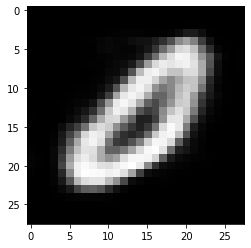

In [212]:
#Decode image
x_decoded = decoder.predict(z)
digit = x_decoded[0].reshape(image_dims[0], image_dims[1])
plt.imshow(digit,cmap="Greys_r")

### Grid

Now lets see what that looks like in a grid. 

We can see how things that are near to each other in latent space have similar characteristics!

The learning process has found a representation that has organised the numbers based on some of the underlying features they possess!

In an ideal world, all of our digit classes would be equally represented so when we sample it to generate new images, we get an accurate representation of the original set. 

In [28]:
#Import functions from cci_autoencoders.py
from cci_autoencoders import plot_label_clusters
from cci_autoencoders import plot_latent_space

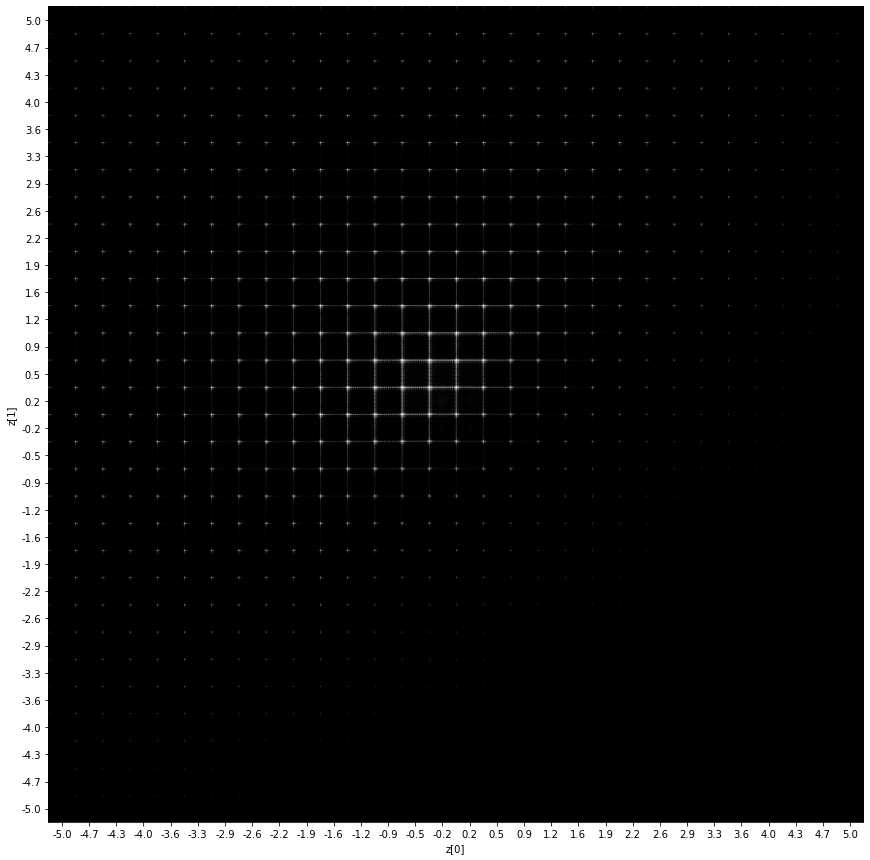

In [183]:
plot_latent_space(decoder)

### Plotting the original dataset

Now lets look at the original dataset. We can use the ``encoder`` to take each image (with the colour representing which digit it is) and plot them in latent space. 

In an ideal world, these would be well spread across the space. However, we can see that the area for 0's and 1's is much bigger and more separated than other digits. 

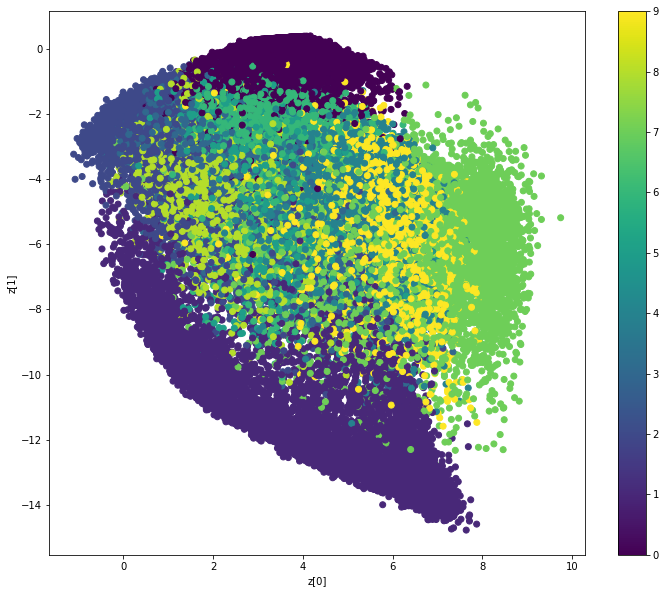

In [93]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

## Variational Autoenconders

There are infact a couple of tweaks to the standard autoencoder setup that allow for both **better quality images** and a **more interesting** and **spread out** latent space. In reality, **Variational Autoencoders** are what anyone would actually use for any practical purposes. 

We've already learned so much new stuff (like total champs), so we won't cover this in much detail now. The main intuition to take is that instead of encoding and decoding each image as **a single point** in latent space, we sample from a **normal distribution** around a given point in latent space (see picture). 


This means the model is slightly different, and we have to account for some extra metrics into the **loss function**. 

To learn more, check Chapter 3 in David Foster - Generative Deep Learning (from the reading list). 


![fishy](../images/vae.png)


``` from David Foster - Generative Deep Learning Chapter 3```


In [19]:
from cci_autoencoders import init_VAE2
from tensorflow import keras

In [22]:
vae = init_VAE2(latent_dim=2)

In [23]:
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=1, batch_size=128)

2022-02-01 19:37:50.848082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


547/547 [==============================] - 16s 28ms/step - loss: 8751.6114 - reconstruction_loss: 6604.4844 - kl_loss: 29.0123


In [25]:
import matplotlib.pyplot as plt

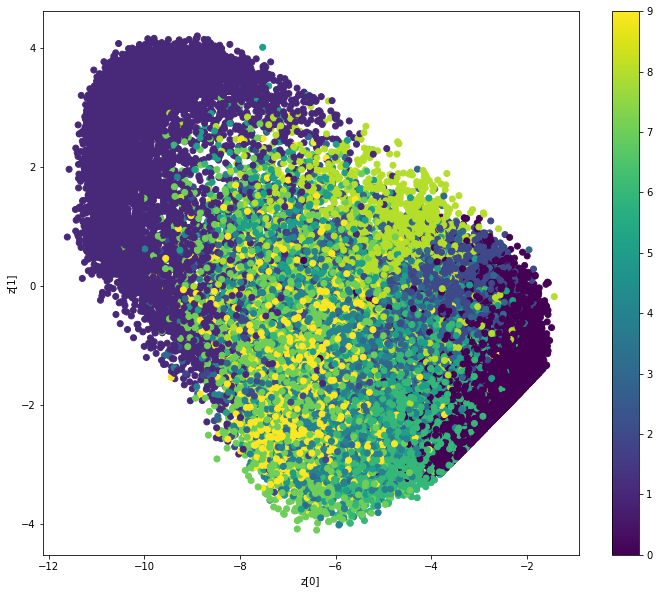

In [26]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
z_mean, _, _ = vae.encoder.predict(x_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

2022-02-01 19:38:50.566562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


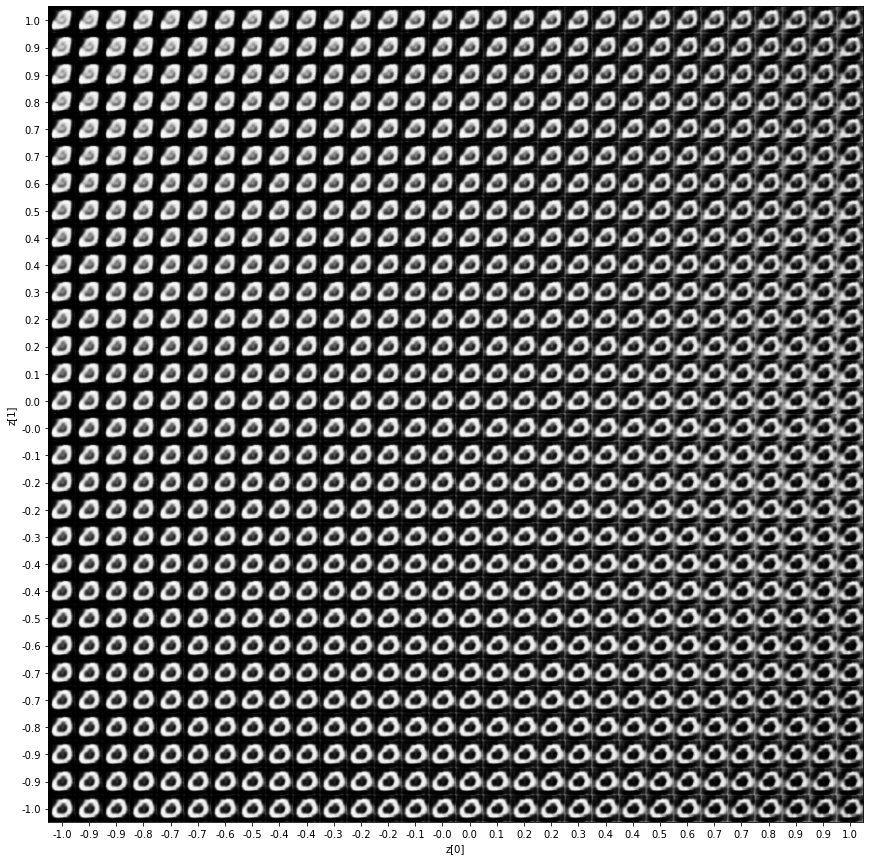

In [29]:
plot_latent_space(vae.decoder, scale = (-1,1))